In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
import kagglehub
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import os
import random

## Importar Dataset con Kaggle
Para correr este notebook se necesita estar loggeado en Kaggle y generar un API token, el cual se sube al colab.

In [49]:
files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle (3).json': b'{"username":"srivera23","key":"f1158767e60c8e7e042f442cc34ebdb2"}'}

Una vez se importe la llave, al correr la siguiente celda de código, el csv debería estar en la ruta --> /kaggle/input/world-energy-consumption

En caso de que salga otra ruta, volver a ejecutar la celda por segunda vez solucionara el problema.

In [50]:
path = kagglehub.dataset_download("pralabhpoudel/world-energy-consumption")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/world-energy-consumption


In [51]:
df = pd.read_csv('/kaggle/input/world-energy-consumption/World Energy Consumption.csv')

In [52]:
df.fillna(0, inplace=True)

In [53]:
df_gran_colombia = df[df['country'].isin(['Panama' , 'Colombia', 'Venezuela', 'Ecuador'])]

In [54]:
print(df_gran_colombia.isna().sum())

country                   0
year                      0
iso_code                  0
population                0
gdp                       0
                         ..
wind_elec_per_capita      0
wind_electricity          0
wind_energy_per_capita    0
wind_share_elec           0
wind_share_energy         0
Length: 129, dtype: int64


In [55]:
df_gran_colombia.head(10)

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
4406,Colombia,1900,COL,4034733.0,4.353822e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4407,Colombia,1901,COL,4112556.0,4.413478e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4408,Colombia,1902,COL,4194368.0,4.486636e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4409,Colombia,1903,COL,4280293.0,4.548537e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4410,Colombia,1904,COL,4367979.0,4.620044e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4411,Colombia,1905,COL,4457462.0,4.696164e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4412,Colombia,1906,COL,4548777.0,4.827840e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4413,Colombia,1907,COL,4641963.0,5.151876e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4414,Colombia,1908,COL,4737057.0,5.448520e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4415,Colombia,1909,COL,4837936.0,5.737221e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_gran_colombia['country'].unique()

array(['Colombia', 'Ecuador', 'Panama', 'Venezuela'], dtype=object)

##Modelo sencillo, solo un páis y predecir energia total

Usaremos solo un país para detectar el funcionamiento y detallar bien el proceso que haremos más adelante

In [56]:
df_colombia = df_gran_colombia[df_gran_colombia["country"] == "Colombia"].sort_values("year").reset_index(drop=True)

In [57]:
df_colombia

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,Colombia,1900,COL,4034733.0,4.353822e+09,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000
1,Colombia,1901,COL,4112556.0,4.413478e+09,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000
2,Colombia,1902,COL,4194368.0,4.486636e+09,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000
3,Colombia,1903,COL,4280293.0,4.548537e+09,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000
4,Colombia,1904,COL,4367979.0,4.620044e+09,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,Colombia,2018,COL,49276968.0,6.519006e+11,21.629,1.638,186.876,9.209,17.452,...,0.025,0.006,1314.330,0.107,0.115,0.812,0.04,2.332,0.051,0.021
119,Colombia,2019,COL,50187404.0,0.000000e+00,4.451,0.410,191.653,9.619,22.715,...,0.166,0.062,45.764,0.052,0.167,1.196,0.06,3.326,0.077,0.030
120,Colombia,2020,COL,50930656.0,0.000000e+00,-13.875,-1.335,162.652,8.284,26.114,...,0.246,0.098,-84.018,-0.140,0.027,0.196,0.01,0.522,0.013,0.005
121,Colombia,2021,COL,51516560.0,0.000000e+00,11.909,0.987,179.952,9.271,24.070,...,0.396,0.147,497.530,0.132,0.158,1.165,0.06,3.071,0.074,0.028


In [58]:
feature_columns = [
 'electricity_demand',
 'primary_energy_consumption',
 'fossil_electricity',
 'low_carbon_electricity',
 'renewables_electricity',
 'electricity_share_energy',
 'per_capita_electricity',
 'energy_cons_change_pct',
 'coal_production',
 'gas_production',
 'oil_production',
 'coal_prod_per_capita',
 'gas_prod_per_capita',
 'oil_prod_per_capita',
 'coal_prod_change_twh',
 'gas_prod_change_twh',
 'oil_prod_change_twh',
 'population',
 'gdp',
 'energy_per_gdp',
 'energy_per_capita',
]

target_column = "electricity_generation"

In [60]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df_colombia[feature_columns])
y_scaled = scaler_y.fit_transform(df_colombia[[target_column]])

sequence_length = 5
X_seq, y_seq = [], []
for i in range(len(df_colombia) - sequence_length):
    X_seq.append(X_scaled[i:i+sequence_length])
    y_seq.append(y_scaled[i + sequence_length])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

In [61]:
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

In [67]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=8)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0357 - mae: 0.1057 - val_loss: 0.2156 - val_mae: 0.4399
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0140 - mae: 0.0891 - val_loss: 0.0763 - val_mae: 0.2444
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0100 - mae: 0.0699 - val_loss: 0.0123 - val_mae: 0.0860
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0049 - mae: 0.0503 - val_loss: 0.0084 - val_mae: 0.0717
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0057 - mae: 0.0398 - val_loss: 0.0116 - val_mae: 0.0889
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0043 - mae: 0.0364 - val_loss: 0.0106 - val_mae: 0.0782
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0055 - mae: 0.0388 - val_loss: 0.0091 - val_mae: 0.0805
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - mae: 0.0330 - val_loss: 0.0115 - val_mae: 0.0899
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.002

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


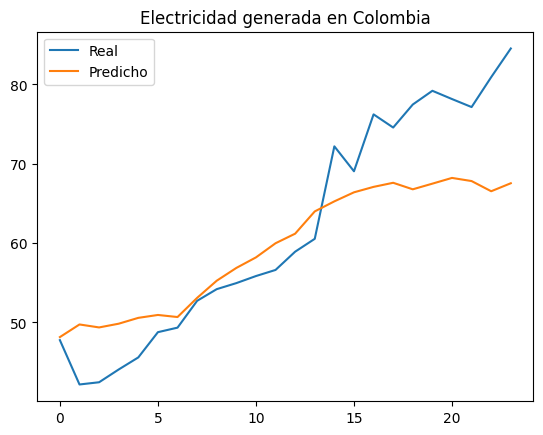

MSE: 55.289593954489725 MAE: 5.939946937561035 R2: 0.7101293598132864


In [69]:
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

plt.plot(y_test_inv, label='Real')
plt.plot(y_pred_inv, label='Predicho')
plt.title("Electricidad generada en Colombia")
plt.legend()
plt.show()

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print("MSE:", mse, "MAE:", mae, "R2:", r2)

##Función para los 4 países


🌍 Entrenando modelo para Colombia
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step


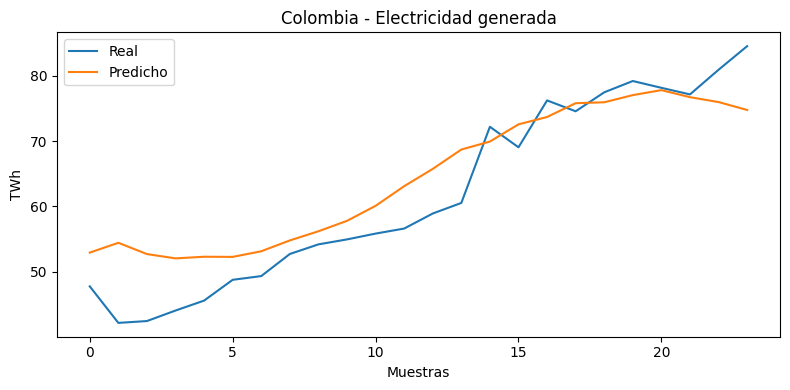

📊 MSE: 31.63, MAE: 4.62, R2: 0.8342

🌍 Entrenando modelo para Ecuador
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


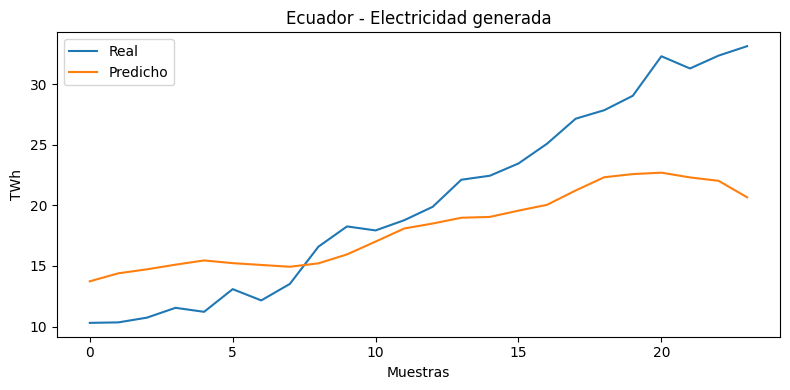

📊 MSE: 29.32, MAE: 4.46, R2: 0.5090

🌍 Entrenando modelo para Panama
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step


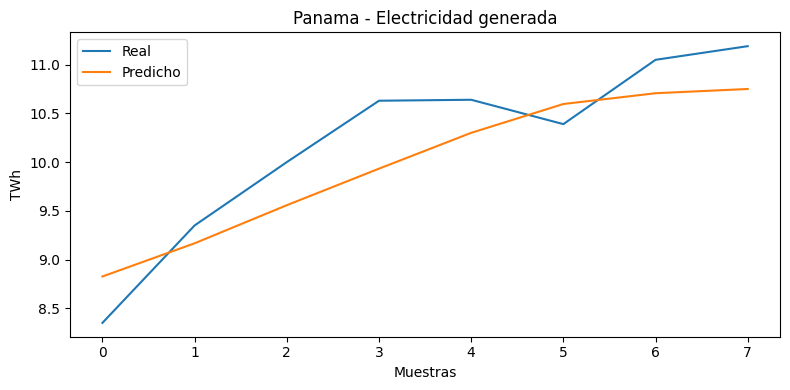

📊 MSE: 0.18, MAE: 0.39, R2: 0.7762

🌍 Entrenando modelo para Venezuela
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


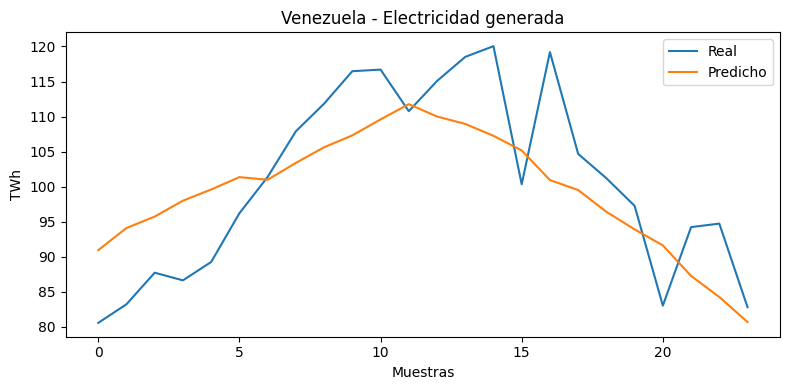

📊 MSE: 70.00, MAE: 7.35, R2: 0.5783


In [ ]:
# ---------- CONFIGURACIÓN ----------
feature_columns = [
    'electricity_demand', 'primary_energy_consumption',
    'fossil_electricity', 'low_carbon_electricity', 'renewables_electricity',
    'electricity_share_energy', 'per_capita_electricity', 'energy_cons_change_pct',
    'coal_production', 'gas_production', 'oil_production',
    'coal_prod_per_capita', 'gas_prod_per_capita', 'oil_prod_per_capita',
    'coal_prod_change_twh', 'gas_prod_change_twh', 'oil_prod_change_twh',
    'population', 'gdp', 'energy_per_gdp', 'energy_per_capita'
]
target_column = 'electricity_generation'
sequence_length = 5

# ---------- ENTRENAR MODELO POR PAÍS ----------
countries = df_gran_colombia['country'].unique()
model_results = {}

for country in countries:
    print(f"\n🌍 Entrenando modelo para {country}")

    df_country = df_gran_colombia[df_gran_colombia['country'] == country].copy()
    df_country = df_country.sort_values('year')

    # Escalar
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(df_country[feature_columns])
    y_scaled = scaler_y.fit_transform(df_country[[target_column]])

    # Crear secuencias
    X_seq, y_seq = [], []
    for i in range(len(df_country) - sequence_length):
        X_seq.append(X_scaled[i:i + sequence_length])
        y_seq.append(y_scaled[i + sequence_length])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    # División temporal
    split_idx = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Modelo LSTM
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),  # ✅
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Entrenamiento
    model.fit(X_train, y_train, validation_data=(X_test, y_test),
              epochs=50, batch_size=8, verbose=0, callbacks=[early_stop])

    # Predicción y evaluación
    y_pred = model.predict(X_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    y_test_inv = scaler_y.inverse_transform(y_test)

    mse = mean_squared_error(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)

    model_results[country] = {
        'model': model,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    }

    # Gráfico
    plt.figure(figsize=(8, 4))
    plt.plot(y_test_inv, label='Real')
    plt.plot(y_pred_inv, label='Predicho')
    plt.title(f"{country} - Electricidad generada")
    plt.xlabel("Muestras")
    plt.ylabel("TWh")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"📊 MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")

## Predicción 5 años que siguen

Mantiene los features constantes del último año (2022)


🔮 Predicción futura para Colombia


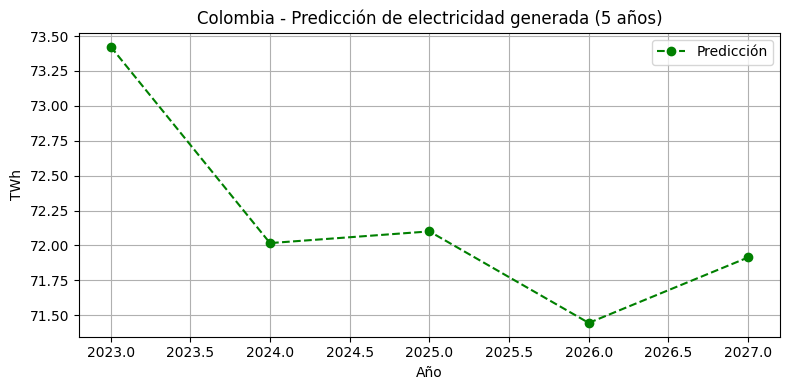

Años predichos: [2023, 2024, 2025, 2026, 2027]
Valores predichos (TWh): [np.float32(73.42426), np.float32(72.01662), np.float32(72.10043), np.float32(71.44468), np.float32(71.91398)]

🔮 Predicción futura para Ecuador


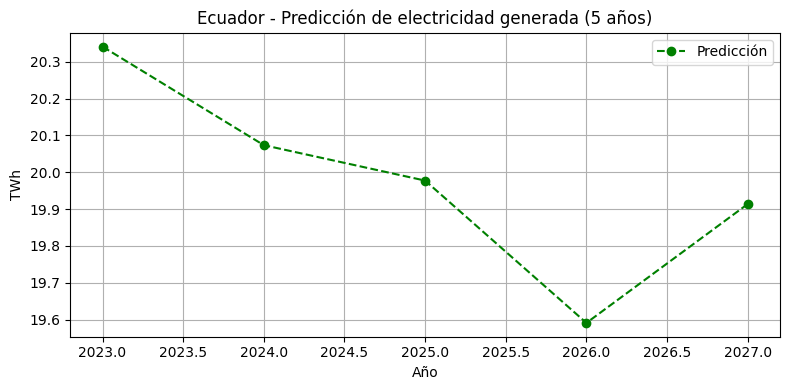

Años predichos: [2023, 2024, 2025, 2026, 2027]
Valores predichos (TWh): [np.float32(20.340971), np.float32(20.073557), np.float32(19.977413), np.float32(19.591196), np.float32(19.913815)]

🔮 Predicción futura para Panama


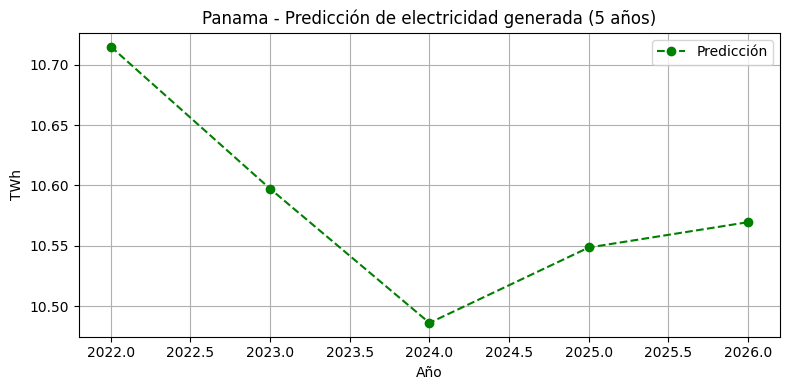

Años predichos: [2022, 2023, 2024, 2025, 2026]
Valores predichos (TWh): [np.float32(10.715116), np.float32(10.597301), np.float32(10.486054), np.float32(10.548587), np.float32(10.569584)]

🔮 Predicción futura para Venezuela


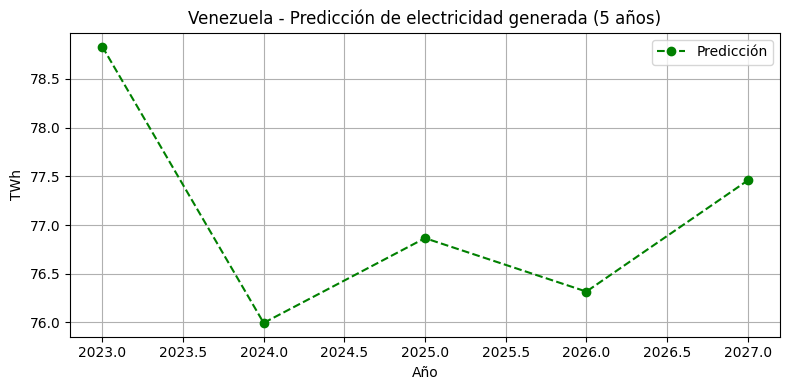

Años predichos: [2023, 2024, 2025, 2026, 2027]
Valores predichos (TWh): [np.float32(78.830826), np.float32(75.99576), np.float32(76.86567), np.float32(76.317116), np.float32(77.45762)]


In [ ]:
future_years = 5

for country in countries:
    print(f"\n🔮 Predicción futura para {country}")

    model = model_results[country]['model']
    scaler_X = model_results[country]['scaler_X']
    scaler_y = model_results[country]['scaler_y']

    df_country = df_gran_colombia[df_gran_colombia['country'] == country].copy()
    df_country = df_country.sort_values('year')

    last_year = df_country['year'].max()
    X_future_base = df_country[feature_columns].copy()

    # Escalar los features completos
    X_scaled_full = scaler_X.transform(X_future_base)

    # Usamos la última ventana temporal como punto de partida
    last_seq = X_scaled_full[-sequence_length:].copy()
    future_preds = []
    future_years_list = []

    for i in range(future_years):
        input_seq = last_seq.reshape(1, sequence_length, -1)

        # Predecir el siguiente valor de electricidad generada
        y_pred_scaled = model.predict(input_seq, verbose=0)
        y_pred = scaler_y.inverse_transform(y_pred_scaled)[0][0]
        future_preds.append(y_pred)

        # Opcional: actualizar variables si estimas su evolución, o mantener constantes
        # Aquí se conserva la última fila repetida (simplificación)
        new_row = last_seq[-1].copy()
        last_seq = np.vstack([last_seq[1:], new_row])  # Desplaza ventana
        future_years_list.append(last_year + i + 1)

    # Mostrar resultado
    plt.figure(figsize=(8, 4))
    plt.plot(future_years_list, future_preds, marker='o', linestyle='--', color='green', label='Predicción')
    plt.title(f"{country} - Predicción de electricidad generada ({future_years} años)")
    plt.xlabel("Año")
    plt.ylabel("TWh")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Años predichos: {future_years_list}")
    print(f"Valores predichos (TWh): {future_preds}")